In [117]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [118]:
df=pd.read_csv('sample_data/ratings.csv')

In [119]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [120]:
df.userId=pd.Categorical(df.userId)
df['new_user_id']=df.userId.cat.codes

In [121]:
df.movieId=pd.Categorical(df.movieId)
df['new_movie_id']=df.movieId.cat.codes

In [122]:
user_ids=df['new_user_id'].values
movie_ids=df['new_movie_id'].values
ratings=df['rating'].values-2.5

In [123]:
N=len(set(user_ids))

In [124]:
M=len(set(movie_ids))

In [125]:
D=10

In [126]:
class Model(nn.Module):
  def __init__(self,n_users,n_items,embed_dim,n_hidden=1024):
    super(Model,self).__init__()
    self.N=n_users
    self.M=n_items
    self.D=embed_dim

    self.u_emb=nn.Embedding(self.N,self.D)
    self.m_emb=nn.Embedding(self.M,self.D)
    self.fc1=nn.Linear(2*self.D,n_hidden)
    self.fc2=nn.Linear(n_hidden,1)
    

  def forward(self,u,m):
    u=self.u_emb(u)  #output is (num_samples,D)
    m=self.m_emb(m)  #output is (num_samples,D)
    #merge
    out=torch.cat((u,m),1)  #output is (num_samples,2D)
    #ANN
    out=self.fc1(out)
    out=F.relu(out)
    out=self.fc2(out)
    return out



    

In [127]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [128]:
print(device)

cpu


In [129]:
model=Model(N,M,D)
model.to(device)

Model(
  (u_emb): Embedding(610, 10)
  (m_emb): Embedding(9724, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [130]:
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters())

In [131]:
user_ids,movie_ids,ratings=shuffle(user_ids,movie_ids,ratings)

In [132]:
user_ids_t=torch.from_numpy(user_ids).long()
movie_ids_t=torch.from_numpy(movie_ids).long()
ratings_t=torch.from_numpy(ratings)

In [133]:
Ntrain=int(0.8*len(ratings))
train_dataset=torch.utils.data.TensorDataset(
    user_ids_t[:Ntrain],
    movie_ids_t[:Ntrain],
    ratings_t[:Ntrain],

)

In [134]:
test_dataset=torch.utils.data.TensorDataset(
    user_ids_t[Ntrain:],
    movie_ids_t[Ntrain:],
    ratings_t[Ntrain:],
)

In [135]:
Ntrain

80668

In [136]:
train_dataset

In [137]:
test_dataset

In [138]:
#Data Loaders
batch_size=512
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)


In [142]:
#a function to encapsulate the training loop
def batch_gd(model,criterion,optimizer,train_iter,test_iter,epochs):
    train_losses=np.zeros(epochs)
    test_losses=np.zeros(epochs)
 
    
    for it in range(epochs):
      train_loss=[]
      for users,movies,targets in train_loader:
        targets=targets.view(-1,1).float()
        #move data to GPU
        users,movies,targets=users.to(device),movies.to(device),targets.to(device)
        #zero to parameter gradients
        optimizer.zero_grad()
      
        #Forward pass
        outputs=model(users,movies)
        loss=criterion(outputs,targets)
        #backward and optimize
        loss.backward()
        optimizer.step()
        #get trainloss and test loss
        train_loss.append(loss.item())
        
      train_loss=np.mean(train_loss)
      
      test_loss=[]
      for users,movies,targets in test_loader:
        users,movies,targets=users.to(device),movies.to(device),targets.to(device)
        targets=targets.view(-1,1).float()
        outputs=model(users,movies)
        loss=criterion(outputs,targets)
        test_loss.append(loss.item())
      test_loss=np.mean(test_loss)
      #save losses
      train_losses[it]=train_loss
      test_losses[it]=test_loss
      

    
      print(f'Epoch {it+1}/{epochs},Train Loss:{train_loss:.4f},'f'Test Loss:{test_loss:.4f}')
    return train_losses,test_losses




In [143]:
train_losses,test_losses=batch_gd( \
                model,criterion,optimizer,train_loader,test_loader,25)

Epoch 1/25,Train Loss:0.5689,Test Loss:0.8268
Epoch 2/25,Train Loss:0.5624,Test Loss:0.8217
Epoch 3/25,Train Loss:0.5532,Test Loss:0.8225
Epoch 4/25,Train Loss:0.5475,Test Loss:0.8323
Epoch 5/25,Train Loss:0.5418,Test Loss:0.8283
Epoch 6/25,Train Loss:0.5319,Test Loss:0.8346
Epoch 7/25,Train Loss:0.5265,Test Loss:0.8367
Epoch 8/25,Train Loss:0.5181,Test Loss:0.8300
Epoch 9/25,Train Loss:0.5136,Test Loss:0.8397
Epoch 10/25,Train Loss:0.5040,Test Loss:0.8472
Epoch 11/25,Train Loss:0.4991,Test Loss:0.8429
Epoch 12/25,Train Loss:0.4927,Test Loss:0.8414
Epoch 13/25,Train Loss:0.4865,Test Loss:0.8558
Epoch 14/25,Train Loss:0.4793,Test Loss:0.8562
Epoch 15/25,Train Loss:0.4717,Test Loss:0.8569
Epoch 16/25,Train Loss:0.4664,Test Loss:0.8649
Epoch 17/25,Train Loss:0.4626,Test Loss:0.8669
Epoch 18/25,Train Loss:0.4538,Test Loss:0.8728
Epoch 19/25,Train Loss:0.4497,Test Loss:0.8793
Epoch 20/25,Train Loss:0.4435,Test Loss:0.8748
Epoch 21/25,Train Loss:0.4382,Test Loss:0.8881
Epoch 22/25,Train Loss

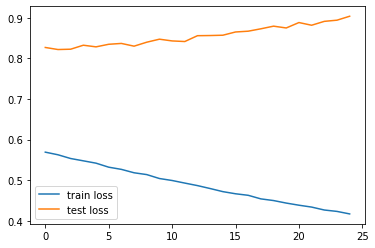

In [144]:
plt.plot(train_losses,label='train loss')
plt.plot(test_losses,label='test loss')
plt.legend()
plt.show()